In [114]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
sns.set()
from hmmlearn.hmm import GaussianHMM

In [72]:
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

Загружаем и очищаем все 4 тома

In [73]:
text = ""
for i in range(1, 5):
    with open(f'war_and_peace/tom_{i}.txt', 'r') as f:
        tom = f.read().lower()
    
    text = text + words_only(tom) + " "

Вычисляем матрицу переходных вероятностей.

In [42]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS_RU = {l: i for i, l in enumerate(RUSSIAN)}

In [43]:
probabilities_ru = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [44]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities_ru[POS_RU[cp], POS_RU[cn]] += 1

In [45]:
probabilities_ru = (probabilities_ru / probabilities_ru.sum(axis=1)[:, None])

In [46]:
df = pd.DataFrame(probabilities_ru, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

Строим heatmap

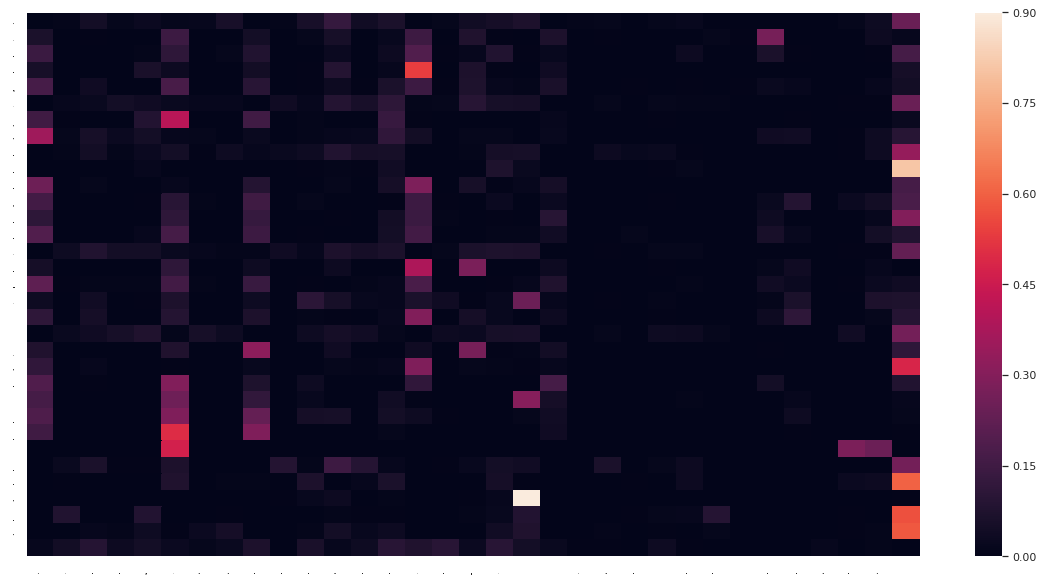

In [52]:
plt.figure(figsize=(20,10))
sns.heatmap(df, xticklabels=list(RUSSIAN), yticklabels=list(RUSSIAN))
plt.show()

Почему-то не рендерится легенда...

Посчитаем вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р

In [61]:
def get_letter_and_prob(prev_letter=None, alfabet=RUSSIAN, probabilities=probabilities_ru, POS=POS_RU):
    if prev_letter is None:
        for s in list(alfabet):
            yield s, probabilities[POS[' '], POS[s]]
    else:
        for s in list(alfabet):
            yield s, probabilities[POS[prev_letter], POS[s]]

In [67]:
words = []
s1 = 'п'
s4 = 'р'
p1 = 1./len(RUSSIAN)
for s2, p2 in get_letter_and_prob(s1):
    for s3, p3 in get_letter_and_prob(s2):
        p4 = probabilities_ru[POS_RU[s3], POS_RU[s4]]
        words.append((s1 + s2 + s3 + s4, p1 * p2 * p3 * p4))

In [68]:
words = sorted(words, key = lambda w: w[1], reverse=True)
words[:20]

[('прер', 0.00012335774136099814),
 ('прор', 9.365605562565728e-05),
 ('прар', 7.633171199780586e-05),
 ('по р', 6.769704247051618e-05),
 ('потр', 4.18492411696942e-05),
 ('попр', 4.1027899749022824e-05),
 ('погр', 3.945928989911442e-05),
 ('подр', 3.918739476068601e-05),
 ('побр', 3.003295011537867e-05),
 ('поер', 2.6507413545261443e-05),
 ('пе р', 2.063622671537994e-05),
 ('пь р', 1.7392765252158383e-05),
 ('прур', 1.5698946906936143e-05),
 ('повр', 1.4618331706949343e-05),
 ('пепр', 1.2102500324004539e-05),
 ('пегр', 1.1397497058526789e-05),
 ('прир', 1.0008821408897551e-05),
 ('покр', 9.999234295523943e-06),
 ('па р', 9.695353027294278e-06),
 ('пофр', 9.201387447410195e-06)]

Суммируем все вероятности и получаем итоговую вероятность:

In [69]:
prob = sum([w[1] for w in words])
prob

0.0009784986358971572

Напишем функцию, генерирующую слово заданной длинны

In [103]:
def gen_word(start='б', length=8):
    word = start
    prev_letter = start
    for i in range(length-1):
        while True: # Альтернатива циклу - подсовывать алфавит без пробела и пересчитать вероятности
            next_letter = np.random.choice(list(RUSSIAN), p=probabilities_ru[POS_RU[prev_letter]])
            if next_letter != ' ': # пробел внутри слова - весьма странно
                word += next_letter
                prev_letter = next_letter
                break
    
    # последняя буква должна выбираться с учетом пробела после слова
    probas = []
    letters = []
    for l in RUSSIAN[:-1]:
        proba = probabilities_ru[POS_RU[prev_letter], POS_RU[l]] * probabilities_ru[POS_RU[l], POS_RU[' ']]
        if proba > 0:
            probas.append(proba)
            letters.append(l)
    
    probas = probas / sum(probas)
    word += np.random.choice(letters, p=probas)
    
    return word

In [108]:
[gen_word() for _ in range(20)]

['бойлохори',
 'босятвеха',
 'бридуласл',
 'бянубраше',
 'бялсемали',
 'быймихоил',
 'быйспобра',
 'бысоньннь',
 'бовсьеовы',
 'бодечтьни',
 'быллькрам',
 'бобройскл',
 'бытетрета',
 'бывыструз',
 'будойсьих',
 'бмолоянча',
 'блойтоскр',
 'бемеружни',
 'бысялакая',
 'бедогдера']

Выбрать ряд с datamarket.com не получается - сайт не открывается, берем для опытов давно полюбившийся ряд с регистрациями автомобилей.

In [109]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')
series = df['Monthly U.S. auto registration (thousands) 1947 ? 1968']
values = series.values.reshape(-1,1)

In [124]:
scores = []
for n in tqdm(range(1, 40)):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    scores.append((n, model.score(values)))

In [128]:
scores

[(1, -1718.8444015815162),
 (2, -1620.718724109844),
 (3, -1556.7373048635795),
 (4, -1525.3655221556367),
 (5, -1506.3948532870368),
 (6, -1496.6093444773878),
 (7, -1485.2254839978116),
 (8, -1480.5481197228987),
 (9, -1476.9016067087289),
 (10, -1466.9940456074441),
 (11, -1464.1175939486093),
 (12, -1450.5481507803074),
 (13, -1441.7629106871314),
 (14, -1443.2481311136385),
 (15, -1431.8112178118954),
 (16, -1412.611276424949),
 (17, -1415.5593310226973),
 (18, -1403.0868914978905),
 (19, -1399.8118356055415),
 (20, -1386.6423864050769),
 (21, -1376.2760189447129),
 (22, -1379.0653433517425),
 (23, -1381.6953514534284),
 (24, -1359.5450004532945),
 (25, -1362.1269285506046),
 (26, -1349.976916516451),
 (27, -1355.6506587029337),
 (28, -1334.1771762169951),
 (29, -1334.1752257093258),
 (30, -1325.2650749712736),
 (31, -1315.5750529368074),
 (32, -1303.3438803539157),
 (33, -1325.3328592795815),
 (34, -1312.1612478973789),
 (35, -1290.6164032993024),
 (36, -1281.8675231407199),
 (37

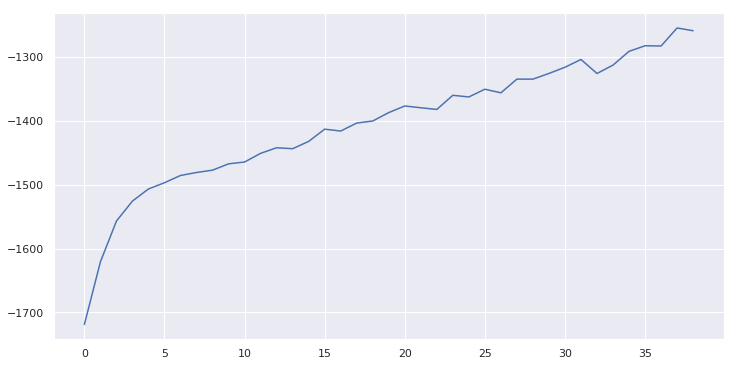

In [127]:
plt.figure(figsize=(12, 6))
plt.plot([x[1] for x in scores ])

Сравним модель с 20 комопнентами и с 38.

In [131]:
model20 = GaussianHMM(n_components=20, covariance_type="diag", n_iter=1000)
model20.fit(values)
labels20 = model20.predict(values)
means20 = np.zeros_like(values)
for i in range(model20.n_components):
    means20[labels20 == i] = model20.means_[i]


In [133]:
model38 = GaussianHMM(n_components=38, covariance_type="diag", n_iter=1000)
model38.fit(values)
labels38 = model38.predict(values)
means38 = np.zeros_like(values)
for i in range(model38.n_components):
    means38[labels38 == i] = model38.means_[i]


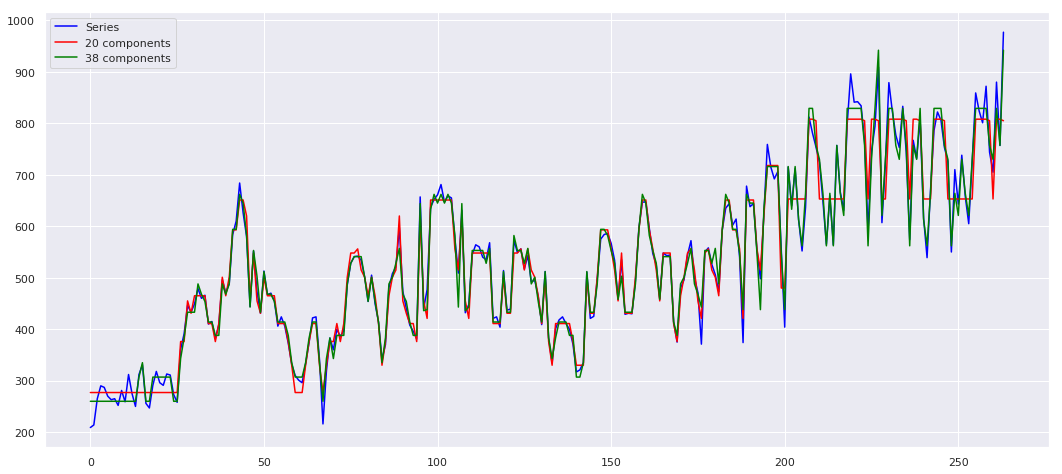

In [136]:
plt.figure(figsize=(18, 8))
plt.plot(values, color='blue', label='Series')
plt.plot(means20, color='red', label='20 components')
plt.plot(means38, color='green', label='38 components')
plt.legend()

Если у последовательность большой размах и есть тренд - то нужно больше компонент, либо подбирать для каждой компоненты свою модель. Либо приводить ряд к стационарному.

In [137]:
def hmm_predict(labels, model, n_comp, n_preds=10):
    cur_value = labels[-1]
    predictions = []
    for _ in range(n_preds):
        cur_value = np.random.choice(n_comp, p=model.transmat_[cur_value])
        predictions.append(model.means_[cur_value])
    return predictions

In [138]:
pred20 = np.concatenate((values, hmm_predict(labels20, model20, 20)))
pred38 = np.concatenate((values, hmm_predict(labels38, model38, 38)))

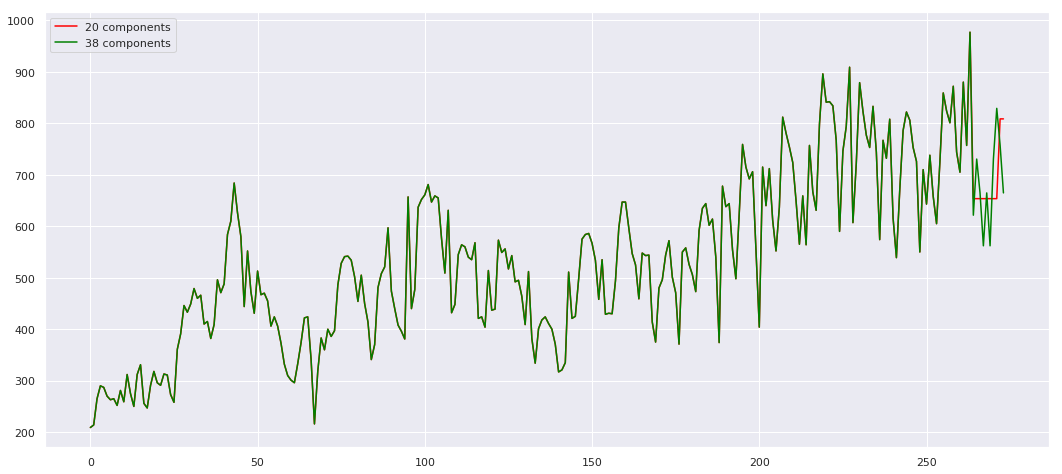

In [139]:
plt.figure(figsize=(18, 8))
plt.plot(pred20, color='red', label='20 components')
plt.plot(pred38, color='green', label='38 components')
plt.legend()

Модель с большим количеством компонент ведет себя ожидаемо лучше.